# Playing around with Quasars

In [43]:
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import vstack

import collections
import numpy as np
import healpy as hp

import pymaster as nmt


In [44]:
def bin_z(cat, edges):
    edges_full = [0.] + list(edges) + [1E300]  #David's better version
    cat_bin = [cat[(cat['Z']>=edges_full[i]) & (cat['Z']<edges_full[i+1])]
               for i in range(len(edges)+1)]
    return cat_bin

In [64]:
def make_map(field, random):
    nside = 512
    
    print(field['RA'].values)
    field_ra = np.radians(field['RA']) #Phi
    field_dec = np.radians(field['DEC'].values) #Pi/2 - dec = theta
    random_ra = np.radians(random['RA'].values) 
    random_dec = np.radians(random['DEC'].values) 
    
    field_FKP = np.array(field['WEIGHT_FKP'].values) 
    field_SYSTOT = np.array(field['WEIGHT_SYSTOT'].values) 
    field_CP = np.array(field['WEIGHT_CP'].values) 
    field_NOZ = np.array(field['WEIGHT_NOZ'].values)
    field_data = field_SYSTOT*field_CP*field_NOZ #FKP left out
    
    random_FKP = np.array(random['WEIGHT_FKP'].values) 
    random_SYSTOT = np.array(random['WEIGHT_SYSTOT'].values) 
    random_CP = np.array(random['WEIGHT_CP'].values) 
    random_NOZ = np.array(random['WEIGHT_NOZ'].values)
    random_data = random_SYSTOT*random_CP*random_NOZ
    
    field_indices = hp.ang2pix(nside, np.pi/2 - field_dec, field_ra) #pixel_indecis
    random_indices = hp.ang2pix(nside, np.pi/2 - random_dec, random_ra)  
    
    field_pixel_data = np.bincount(field_indices, field_data, hp.nside2npix(nside)) 
                                                                        #for each pixel in the resolution, 
                                                                        #Adds all the data entries that 
                                                                        #have been assigned the such pixel
    random_pixel_data = np.bincount(random_indices, random_data, hp.nside2npix(nside))
    
    alpha = sum(field_pixel_data)/sum(random_pixel_data)
    
    pixel_density_data = np.zeros(hp.nside2npix(nside))
    goodpix = random_pixel_data > 0   #avoid dividing by 0
    pixel_density_data[goodpix] = field_pixel_data[goodpix]/(alpha*random_pixel_data[goodpix]) - 1
    
    # The maps are: delta, mask, mean_number
    return np.array([pixel_density_data, random_pixel_data, random_pixel_data*alpha])
    
   

Load the data

In [65]:
#NGC =  fits.open('/mnt/zfsusers/jaimerz/data/eBOSS_QSO_clustering_data-NGC-vDR16.fits')
#NGC_r =  fits.open('/mnt/zfsusers/jaimerz/data/eBOSS_QSO_clustering_random-NGC-vDR16.fits')
#SGC =  fits.open('/mnt/zfsusers/jaimerz/data/eBOSS_QSO_clustering_data-SGC-vDR16.fits')
#SGC_r =  fits.open('/mnt/zfsusers/jaimerz/data/eBOSS_QSO_clustering_random-SGC-vDR16.fits')
prefix = '/home/zcapjru/PhD/Data/'
#prefix = './'
NGC =  fits.open(prefix + 'eBOSS_QSO_clustering_data-NGC-vDR16.fits')
NGC_r =  fits.open(prefix + 'eBOSS_QSO_clustering_random-NGC-vDR16.fits')
SGC =  fits.open(prefix + 'eBOSS_QSO_clustering_data-SGC-vDR16.fits')
SGC_r =  fits.open(prefix + 'eBOSS_QSO_clustering_random-SGC-vDR16.fits')

Information about data

From fits to pandas and then to maps

In [66]:
NGC_table =   Table.read(NGC)
NGC_r_table =  Table.read(NGC_r)
SGC_table =   Table.read(SGC)
SGC_r_table = Table.read(SGC_r)

In [67]:
NGC_data = NGC_table.to_pandas()
NGC_r_data = NGC_r_table.to_pandas()
SGC_data = SGC_table.to_pandas()
SGC_r_data = SGC_r_table.to_pandas()

bin data

In [72]:
%%time
binned_NGC   = bin_z(NGC_data, [1.5])
binned_NGC_r = bin_z(NGC_r_data, [1.5])
binned_SGC   = bin_z(SGC_data, [1.5])
binned_SGC_r = bin_z(SGC_r_data, [1.5])

CPU times: user 1.14 s, sys: 1.12 s, total: 2.27 s
Wall time: 2.36 s


Thread and map

In [88]:
%%time
NGC_maps = []
for i in range(len(binned_NGC)):
    NGC_maps.append(make_map(binned_NGC[i],binned_NGC_r[i] ))
    
SGC_maps = []
for i in range(len(binned_SGC)):
    SGC_maps.append(make_map(binned_SGC[i],binned_SGC_r[i] ))

[150.52726992 247.81096506 211.1298808  ... 260.64858829 137.81386172
 138.09809362]
[126.25211624 114.68553182 116.47152209 ... 202.22863756 143.69115574
 148.86030779]
[ 25.57760734  16.16129642 358.39962336 ... 340.68833545 320.41607666
 322.85757819]
[342.25062104  29.59458675  32.81517946 ... 334.79549919 354.78960605
   5.62447152]
CPU times: user 4.83 s, sys: 2.41 s, total: 7.23 s
Wall time: 8.78 s


Add NGC and SGC 

In [89]:
#Structure: [field, mask]
Whole_maps_1 = SGC_maps[0] + NGC_maps[0]
Whole_maps_2 = SGC_maps[1] + NGC_maps[1]

Plot

/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, 

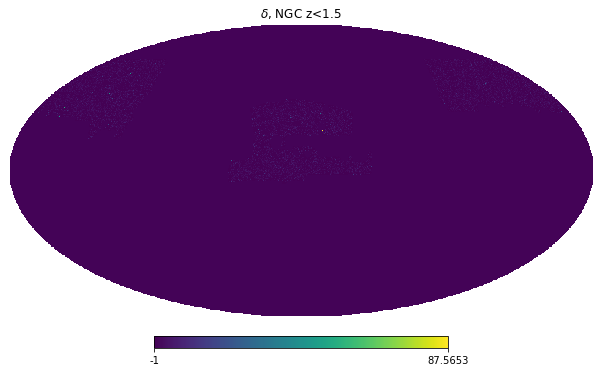

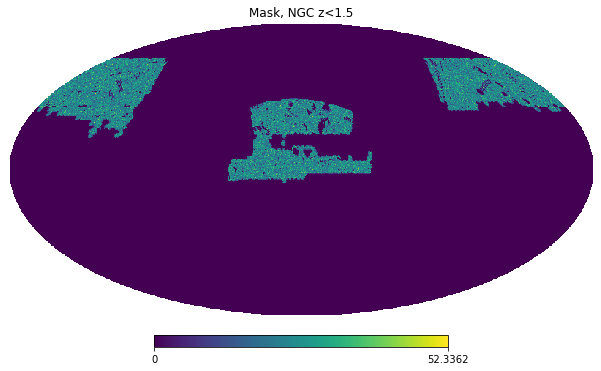

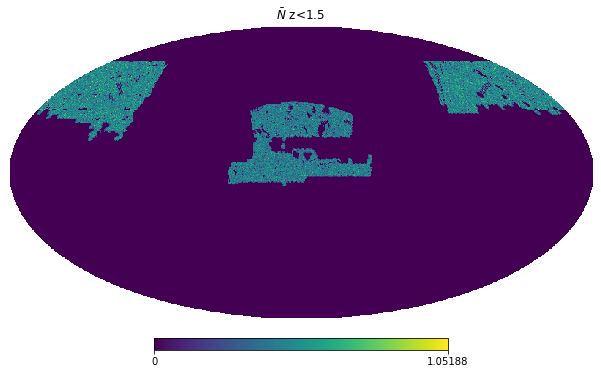

In [90]:
hp.visufunc.mollview(Whole_maps_1[0], title= r'$\delta$, NGC z<1.5')
hp.visufunc.mollview(Whole_maps_1[1], title= r'Mask, NGC z<1.5')
hp.visufunc.mollview(Whole_maps_1[2], title= r'$\bar{N}$ z<1.5')


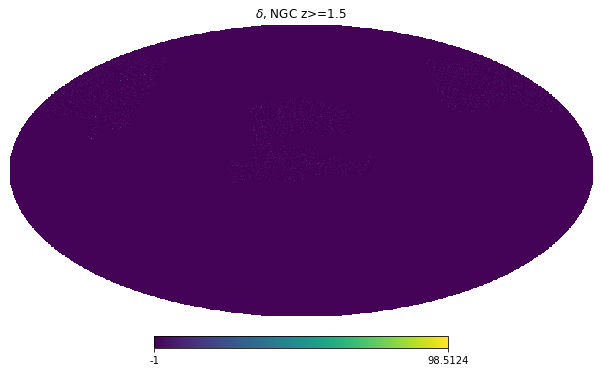

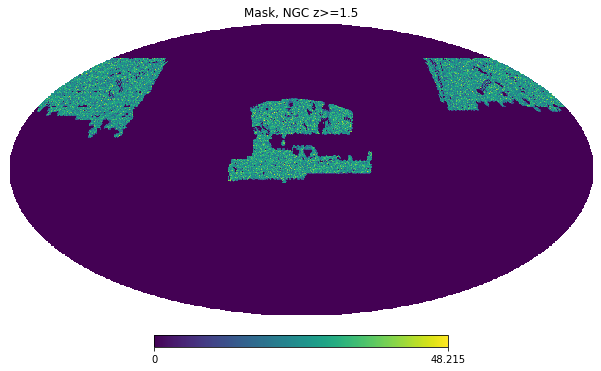

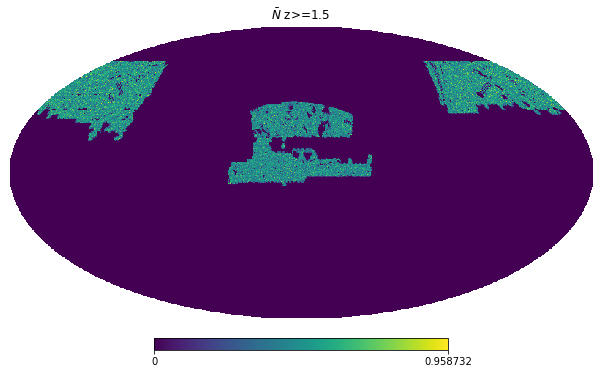

In [91]:
hp.visufunc.mollview(Whole_maps_2[0], title= r'$\delta$, NGC z>=1.5')
hp.visufunc.mollview(Whole_maps_2[1], title= r'Mask, NGC z>=1.5')
hp.visufunc.mollview(Whole_maps_2[2], title= r'$\bar{N}$ z>=1.5')


Make fields

In [103]:
# Read healpix maps and initialize a spin-0 and spin-2 field
f_1 = nmt.NmtField(Whole_maps_1[1], [Whole_maps_1[0]])
f_2 = nmt.NmtField(Whole_maps_2[1], [Whole_maps_2[0]])

Make band powers

In [104]:
# Initialize binning scheme with 20 ells per bandpower
nside = hp.npix2nside(len(Whole_maps_1[0]))
b = nmt.NmtBin.from_nside_linear(nside, 20)

Create Workspace ---> get mode coupling matrix

In [106]:
print(Whole_maps_1[1])

[0. 0. 0. ... 0. 0. 0.]


In [ ]:
w_11 = nmt.NmtWorkspace()
w_11.compute_coupling_matrix(f_1, f_1, b)

w_12 = nmt.NmtWorkspace()
w_12.compute_coupling_matrix(f_1, f_2, b)

w_22 = nmt.NmtWorkspace()
w_22.compute_coupling_matrix(f_2, f_2, b)

Make Cl's using the coupling matrices

In [ ]:
def compute_naive_cl(f_a, f_b, wsp):
    # Compute the power spectrum (a la anafast) of the masked fields
    # Note that we only use n_iter=0 here to speed up the computation,
    # but the default value of 3 is recommended in general.
    cl_coupled = nmt.compute_coupled_cell(f_a, f_b)
    # Decouple power spectrum into bandpowers inverting the coupling matrix
    cl_decoupled = wsp.decouple_cell(cl_coupled) #removed bias here

    return cl_decoupled

In [ ]:
cl_11 = compute_naive_cl(f_1, f_1, w_11)
cl_12 = compute_naive_cl(f_1, f_2, w_12)
cl_22 = compute_naive_cl(f_2, f_2, w_22)

### Remove Poisson noise

In [ ]:
def coupled_nl(mask, n):
    #Assumptions:
    #1) noise is uncorrelated such that the two sums over
    #pixels collapse into one --> True for poisson noise
    #2) Pixel area is a constant --> True for healpy
    
    #Input:
    #mask --> mask 
    #n --> map with mean number of galaxies per pixel 
    
    nside = hp.npix2nside(len(mask))
    pixel_A = 4*np.pi/hp.nside2npix(nside)

    sum_items = np.zeros(hp.nside2npix(nside))
    goodpix = n > 0   #avoid dividing by 0
    sum_items[goodpix] = (mask[goodpix]**2/n[goodpix])

    #David's notes formula
    N_ell = pixel_A*np.mean(sum_items)
        
    #Following Carlos code
    return np.array([N_ell * np.ones(3*nside)])

In [ ]:
nl_11 = w_11.decouple_cell(coupled_nl(Whole_maps_1[1], Whole_maps_1[2]))
nl_22 = w_22.decouple_cell(coupled_nl(Whole_maps_2[1], Whole_maps_2[2]))

In [ ]:
# Plot results
ell_arr = b.get_effective_ells()
plt.plot(ell_arr, nl_11[0], 'r-', label='11')
plt.plot(ell_arr, nl_22[0], 'g-', label='22')

plt.loglog()
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$N_\\ell$', fontsize=16)
plt.legend(loc='upper right', ncol=2, labelspacing=0.1)
plt.show()

In [ ]:
cl_11_no_noise = cl_11-nl_11
cl_12_no_noise = cl_12
cl_22_no_noise = cl_22-nl_22

In [ ]:
# Plot results
ell_arr = b.get_effective_ells()
plt.plot(ell_arr, cl_11_no_noise[0], 'r--', label='11')
plt.plot(ell_arr, cl_11[0], 'r-', label='11 naive')
plt.plot(ell_arr, nl_11[0], 'r-.', label='11 noise')
plt.loglog()
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()

In [ ]:
# Plot results
ell_arr = b.get_effective_ells()
plt.plot(ell_arr, cl_12[0], 'b-', label='12')
plt.loglog()
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='upper right', ncol=2, labelspacing=0.1)
plt.show()

In [ ]:
# Plot results
ell_arr = b.get_effective_ells()
plt.plot(ell_arr, cl_22_no_noise[0], 'g--', label='22')
plt.plot(ell_arr, cl_22[0], 'g-', label='22 naive')
plt.plot(ell_arr, nl_22[0], 'g-.', label='22 noise')
plt.loglog()
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='lower left', ncol=2, labelspacing=0.1)
plt.show()

# Class Wrap 

In [3]:
from astropy.io import fits
from astropy.table import Table

import os
import pandas as pd
import numpy as np
import healpy as hp

import pymaster as nmt


class QuasarMapper:
    def __init__(self): 
        #Inputs: the four fits files from eBOSS DR14
        
        data_path = '/home/zcapjru/PhD/Data/'
        #Check for data files:
        if os.path.exists(data_path+'eBOSS_QSO_clustering_data-NGC-vDR16.fits') :
            print('NGC data found')
            self.NGC_data =  fits.open(data_path + 'eBOSS_QSO_clustering_data-NGC-vDR16.fits')
        else :
            print('missing NGC data')

        if os.path.exists(data_path+'eBOSS_QSO_clustering_data-SGC-vDR16.fits') :
            print('SGC data found')
            self.SGC_data =  fits.open(data_path + 'eBOSS_QSO_clustering_data-SGC-vDR16.fits')
        else :
            print('missing SGC data')
           
        if os.path.exists(data_path+'eBOSS_QSO_clustering_random-NGC-vDR16.fits') :
            print('NGC random data found')
            self.NGC_r_data =  fits.open(data_path + 'eBOSS_QSO_clustering_random-NGC-vDR16.fits')
        else :
            print('missing NGC random data')
           
        if os.path.exists(data_path+'eBOSS_QSO_clustering_random-SGC-vDR16.fits') :
            print('SGC random data found')
            self.SGC_r_data =  fits.open(data_path + 'eBOSS_QSO_clustering_random-SGC-vDR16.fits')
        else :
            print('missing SGC random data')
        

        self.nside = 512
        #set resolution
        
        self.bands = nmt.NmtBin.from_nside_linear(self.nside, 20)
        #set l's per band
        
        self.NGC = Table.read(self.NGC_data).to_pandas()
        self.NGC_r = Table.read(self.NGC_r_data).to_pandas()
        self.SGC = Table.read(self.SGC_data).to_pandas()
        self.SGC_r = Table.read(self.SGC_r_data).to_pandas()
        #from .fits to table to managable pandas frames

        #Merge NGC + SGC
        self.edges = [1.5] #inner bins edges
        self.whole =  pd.concat([self.NGC, self.SGC])
        self.whole_r =  pd.concat([self.NGC_r, self.SGC_r])
        
        self.binned   = self.bin_z(self.whole ,  self.edges)
        self.binned_r = self.bin_z(self.whole_r ,  self.edges)
        #arrays containing the binned data for each field
        
        self.maps = {}
        for i in range(len(self.edges)+1):
            self.nmean_field  =  self.get_nmean_map(self.binned[i])
            self.nmean_random =  self.get_nmean_map(self.binned_r[i])
            self.alpha = self.get_alpha(self.nmean_field, self.nmean_random)
            
            self.maps["bin_{}".format(i)+"_delta"]= self.get_delta_map(self.nmean_field, self.nmean_random, self.alpha) 
            self.maps["bin_{}".format(i)+"_nmean"]= self.nmean_random*self.alpha
            self.maps["bin_{}".format(i)+"_mask"] = self.nmean_random
               
        print('Maps computed succesfully')
        
        self.cls = {}
        for i in range(len(self.edges)+1):
            for j in range(len(self.edges)+1):
                if j>=i:
                    self.f_i = nmt.NmtField(self.maps["bin_{}".format(i)+"_mask"], [self.maps["bin_{}".format(i)+"_delta"]])
                    self.f_j = nmt.NmtField(self.maps["bin_{}".format(j)+"_mask"], [self.maps["bin_{}".format(i)+"_delta"]])
                    self.wsp = nmt.NmtWorkspace()
                    self.wsp.compute_coupling_matrix(self.f_i, self.f_j, self.bands)
                    self.cl = self.get_cl(self.f_i, self.f_j, self.wsp)
                    self.cls["cl_{}".format(i)+"{}".format(j)]= self.cl
                    
                    if i==j:
                        self.mask  = self.maps["bin_{}".format(i)+"_mask"]
                        self.nmean = self.maps["bin_{}".format(i)+"_nmean"]
                        self.nl = self.get_nl(self.mask, self.nmean, self.wsp)
                        self.cls["nl_{}".format(i)+"{}".format(j)]   = self.cl
                        self.cls["cl-nl_{}".format(i)+"{}".format(j)]= self.nl
                    else:
                        self.cls["nl_{}".format(i)+"{}".format(j)]   = np.zeros(len(self.cl))
                        self.cls["cl-nl_{}".format(i)+"{}".format(j)]= self.cl
                        
        print('Cls computed succesfully')       

        
   ###############
   ###############
        
    def bin_z(self, cat, edges):
        #inputs: cat --> unbinned data
        #        edges -> upper boundaries of bins
        edges_full = [0.] + list(edges) + [1E300]  #David's better version
        cat_bin = [cat[(cat['Z']>=edges_full[i]) & (cat['Z']<edges_full[i+1])]
                   for i in range(len(edges)+1)]
        return cat_bin
    
    def get_nmean_map(self, field):
        #imputs: pandas frames
        #Calculates the mean quasar count per pixel of the field
        field_ra = np.radians(field['RA'].values) #Phi
        field_dec = np.radians(field['DEC'].values) #Pi/2 - dec = theta

        field_FKP = np.array(field['WEIGHT_FKP'].values) 
        field_SYSTOT = np.array(field['WEIGHT_SYSTOT'].values) 
        field_CP = np.array(field['WEIGHT_CP'].values) 
        field_NOZ = np.array(field['WEIGHT_NOZ'].values)
        field_data = field_SYSTOT*field_CP*field_NOZ #FKP left out

        field_indices = hp.ang2pix(self.nside, np.pi/2 - field_dec, field_ra) #pixel_indecis

        field_pixel_data = np.bincount(field_indices, field_data, hp.nside2npix(self.nside)) 
                                                                            #for each pixel in the resolution,                                                                 #have been assigned the such pixel

        return field_pixel_data
    
    def get_alpha(self, nmean_field, nmean_random):
        #imputs: pandas frames
        #Calculates the mean quasar count per pixel field to random ratio
        
        alpha = sum(nmean_field)/sum(nmean_random)

        return alpha
    
    def get_delta_map(self, nmean_field, nmean_random, alpha):
        #inputs
        #Calculates the quasar density map of the 
        
        delta_map = np.zeros(hp.nside2npix(self.nside))
        goodpix = nmean_random > 0   #avoid dividing by 0
        delta_map[goodpix] = nmean_field[goodpix]/(alpha*nmean_random[goodpix]) - 1

        # The maps are: delta, mask, mean_number
        return delta_map
    
    def get_cl(self, f_a, f_b, wsp):
        cl_coupled = nmt.compute_coupled_cell(f_a, f_b)
        # Decouple power spectrum into bandpowers inverting the coupling matrix
        cl_decoupled = wsp.decouple_cell(cl_coupled) #removed bias here

        return cl_decoupled
    
    def get_nl(self, mask, nmean, wsp):
        #Assumptions:
        #1) noise is uncorrelated such that the two sums over
        #pixels collapse into one --> True for poisson noise
        #2) Pixel area is a constant --> True for healpy

        #Input:
        #mask --> mask 
        #n --> map with mean number of galaxies per pixel 

        pixel_A = 4*np.pi/hp.nside2npix(self.nside)

        sum_items = np.zeros(hp.nside2npix(self.nside))
        goodpix = nmean > 0   #avoid dividing by 0
        sum_items[goodpix] = (mask[goodpix]**2/nmean[goodpix])

        #David's notes formula
        N_ell = pixel_A*np.mean(sum_items)
        
        nl_coupled = np.array([N_ell * np.ones(3*self.nside)])
        nl_decouple = wsp.decouple_cell(nl_coupled) #removed bias here

        #Following Carlos code
        return nl_decouple

output = QuasarMapper()

f = open("cls.txt","w")
f.write( str(output.cls) )
f.close()

f = open("maps.txt","w")
f.write( str(output.maps) )
f.close()

NGC data found
SGC data found
NGC random data found
SGC random data found
Maps computed succesfully
Cls computed succesfully


In [78]:
from astropy.io import fits
from astropy.table import Table

import os
import pandas as pd
import numpy as np
import healpy as hp



class QuasarMapper:
    def __init__(self,  path_datas , path_randoms, prefix = 'quasar_', edges = [1.5], nside = 512): 
        #Inputs: 1) a tracer label for future reference, defaulted to 'quasar'
        #        2) an array of paths to data fields
        #        3) an array of paths to random fields
        #        4) an array of bin inner boundaries  
        #        5) resolution, defaulted to 512
        
        #make sure all data paths exist can store them in a dic
        #Will this break if lists are asymmetrical?
        self.prefix = prefix
        self.cat_data = []
        self.cat_random = []
        for file_data, file_random in zip(path_datas, path_randoms):
            if not os.path.isfile(file_data):
                raise ValueError(f"File {file_data} not found")
            with fits.open(file_data) as f:
                self.cat_data.append(Table.read(f).to_pandas())
            if not os.path.isfile(file_random):
                raise ValueError(f"File {file_random} not found")
            with fits.open(file_random) as f:
                self.cat_random.append(Table.read(f).to_pandas())

            

        #set resolution
        self.nside = nside

        #Merge all data mappings into one single sky map 
        self.cat_data = pd.concat(self.cat_data)
        self.cat_random = pd.concat(self.cat_random)
        
        #Bin data                              
        self.edges = edges #inner bins edges
        self.binned   = self.__bin_z(self.cat_data ,  self.edges)
        self.binned_r = self.__bin_z(self.cat_random ,  self.edges)
        #arrays containing the binned data for each field
        
        #Store maps
        self.maps = {}
        for i in range(len(self.edges)+1):
            self.mask_field  =  self.__get_mask(self.binned[i])
            self.mask_random =  self.__get_mask(self.binned_r[i])
            self.alpha = self.__get_alpha(self.mask_field, self.mask_random)
            self.nmean = self.__get_nmean(self.mask_random, self.alpha)
            self.delta = self.__get_delta_map(self.mask_field, self.mask_random, self.alpha)
                                       
            self.maps[self.prefix + "bin_{}".format(i+1)+"_delta"]= self.delta
            self.maps[self.prefix + "bin_{}".format(i+1)+"_nmean"]= self.nmean
            self.maps[self.prefix + "bin_{}".format(i+1)+"_mask"] = self.mask_random
                   
        #Store noise power spectra
        self.nls = {}
        for i in range(len(self.edges)+1):
            for j in range(len(self.edges)+1):
                if j>=i:
                    if i==j:
                        self.mask  = self.maps[self.prefix+"bin_{}".format(i+1)+"_mask"]
                        self.nmean = self.maps[self.prefix+"bin_{}".format(i+1)+"_nmean"]
                        self.nl = self.__get_nl(self.mask, self.nmean)
                        self.nls[self.prefix + "nl_{}".format(i+1)+"{}".format(j+1)]   = self.nl
                    else:
                        self.nls[self.prefix + "nl_{}".format(i+1)+"{}".format(j+1)]   = np.zeros(3*self.nside)
        
   ###############
   #PRIVATE METHODS
   ###############
        
    def __bin_z(self, cat, edges):
        #inputs: cat --> unbinned data
        #        edges -> upper boundaries of bins
        edges_full = [0.] + list(edges) + [1E300]  #David's better version
        cat_bin = [cat[(cat['Z']>=edges_full[i]) & (cat['Z']<edges_full[i+1])]
                   for i in range(len(edges)+1)]
        return cat_bin
                                       
    def __get_mask(self, field):
        #imputs: pandas frames
        #Calculates the mean quasar count per pixel of the field
        field_ra = np.radians(field['RA'].values) #Phi
        field_dec = np.radians(field['DEC'].values) #Pi/2 - dec = theta

        field_FKP = np.array(field['WEIGHT_FKP'].values) 
        field_SYSTOT = np.array(field['WEIGHT_SYSTOT'].values) 
        field_CP = np.array(field['WEIGHT_CP'].values) 
        field_NOZ = np.array(field['WEIGHT_NOZ'].values)
        field_data = field_SYSTOT*field_CP*field_NOZ #FKP left out

        field_indices = hp.ang2pix(self.nside, np.pi/2 - field_dec, field_ra) #pixel_indecis

        field_pixel_data = np.bincount(field_indices, field_data, hp.nside2npix(self.nside)) 
                                                                            #for each pixel in the resolution,                                                                 #have been assigned the such pixel

        return field_pixel_data
    
    def __get_nmean(self, mask, alpha ):
        return mask*alpha
    
    def __get_alpha(self, nmean_field, nmean_random):
        #imputs: pandas frames
        #Calculates the mean quasar count per pixel field to random ratio
        
        alpha = sum(nmean_field)/sum(nmean_random)

        return alpha
    
    def __get_delta_map(self, nmean_field, nmean_random, alpha):
        #inputs
        #Calculates the quasar density map of the 
        
        delta_map = np.zeros(hp.nside2npix(self.nside))
        goodpix = nmean_random > 0   #avoid dividing by 0
        delta_map[goodpix] = nmean_field[goodpix]/(alpha*nmean_random[goodpix]) - 1

        # The maps are: delta, mask, mean_number
        return delta_map
                                       
    
    def __get_nl(self, mask, nmean):
        #Assumptions:
        #1) noise is uncorrelated such that the two sums over
        #pixels collapse into one --> True for poisson noise
        #2) Pixel area is a constant --> True for healpy

        #Input:
        #mask --> mask 
        #n --> map with mean number of galaxies per pixel 

        pixel_A = 4*np.pi/hp.nside2npix(self.nside)

        sum_items = np.zeros(hp.nside2npix(self.nside))
        goodpix = nmean > 0   #avoid dividing by 0
        sum_items[goodpix] = (mask[goodpix]**2/nmean[goodpix])

        #David's notes formula
        N_ell = pixel_A*np.mean(sum_items)
        
        nl_coupled = np.array([N_ell * np.ones(3*self.nside)])
        #nl_decouple = wsp.decouple_cell(nl_coupled) #removed bias here

        #Following Carlos code
        return nl_coupled
                        
    ###############
    #PUBLIC METHODS
    ###############
                                       
    def get_delta_map(self, i):
        #input: bin lable i as a float
        return self.maps[self.prefix +"bin_{}".format(i)+"_delta"]
                                       
    def get_nmean_map(self, i):
        #input: bin lable i as a float
        return self.maps[self.prefix +"bin_{}".format(i)+"_nmean"]
                                       
    def get_mask(self, i):
        #input: bin lable i as a float
        return self.maps[self.prefix +"bin_{}".format(i)+"_mask"]
                                       
    def get_nl(self, i, j):
        #input: bin lable i as a float
        return self.nls[self.prefix +"nl_{}".format(i)+"{}".format(j)]
                                       
                                       

In [79]:
class_example = QuasarMapper(input_1, input_2)

In [80]:
data_path = '/home/zcapjru/PhD/Data/'
input_1 = [data_path+'eBOSS_QSO_clustering_data-NGC-vDR16.fits', data_path+'eBOSS_QSO_clustering_data-SGC-vDR16.fits']
input_2 = [data_path+'eBOSS_QSO_clustering_random-NGC-vDR16.fits', data_path+'eBOSS_QSO_clustering_random-SGC-vDR16.fits']

In [83]:
class_example.get_nl(1,1)

array([[0.00061585, 0.00061585, 0.00061585, ..., 0.00061585, 0.00061585,
        0.00061585]])